# Playing with raw image data

The aim of this notebook is to play with image processing, and namely:
* load a bitmap image 
* find the ultrasound signal which was used to create this image (up to the phase) and get a dump of this [raw signal](SinUs.csv.gz).
* see how we can use this signal to find back the image, and define an error function to have a metrics.

How will you be able to process the raw signal to find back the original image?


In [27]:
from __future__ import print_function
import numpy as np
from PIL import Image # for bmp import
from glob import glob
import matplotlib.pyplot as plt
import math
import time

%matplotlib inline

def ShowImage(ImageToPlot):
    plt.figure(figsize=(2, 4))
    plt.gray()
    plt.imshow(ImageToPlot.reshape(ImageToPlot.shape), aspect='auto')
    plt.show()
    
def ssd(A,B):
    A = A - 0.95*A.min()
    A = 1.0*A/A.max()
    B = B - 0.95*B.min()
    B = 1.0*B/B.max()
    squares = (A[:,:] - B[:,:]) ** 2
    return np.sum(squares)

def NormImag(A):
# Let's normalize the image
    A = A - A.min()
    A = 1.0*A/A.max()
    return(A)

We're getting the 342x719 image of a phantom. 

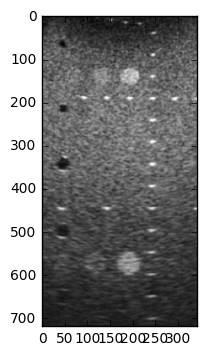

In [28]:
im = Image.open("fantom.bmp").convert('L') # convert 'L' is to get a flat image, not RGB
Depth = 0.13 # in meters
Img = NormImag(np.array(im)) # we use the full [0;1] range
ShowImage(Img)

Let's assume vertical line points are spaced by 1cm each. We'd get a depth of around 13cm - that's 5.53 pts / mm.
At a speed of 1450m/s for sound, we'd have a listening time of around 0.13*2/1450 ~ 180µs of recording.

In [29]:
resolution = Img.shape[0]/Depth # in pts/m
t = Depth*2.0/1450.0

Let's assume a ADC sampling rate of 60Msps (close to our prototype) and a piezo frequency f = 3.5 MHz. That would give a raw signal of length Msps*t, reaching close to 11k points.

In [30]:
sps = 60.0E6
f = 3.5E6
L = int(t*sps)

We can then recreate the raw signal image, and save it in a [compressed CSV format](SinUs.csv.gz). Note that nump 'load' transparently accepts gz files.

In [31]:
SinUs = np.zeros(shape=(L,Img.shape[1]))
for i in range(len(SinUs)):
    for j in range(len(SinUs[0])):
        pixelValue = 1.0*Img[i*Img.shape[0]/L][j]
        w = 2.0*math.radians(180)*f
        SinUs[i][j] = pixelValue*math.cos(1.0*i*w/sps)
# Let's save the raw signal data
np.savetxt("SinUs.csv.gz",SinUs, delimiter=';')

Let's check that we have the image (in green) and the corresponding signal (in blue)

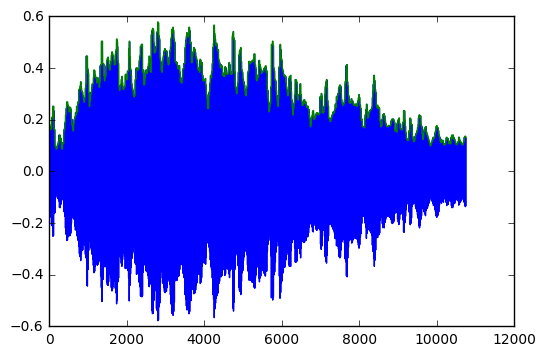

In [32]:
Line = np.zeros(shape=(L))
ImageLine = np.zeros(shape=(L))
for i in range(len(SinUs)):
    Line[i] =  SinUs[i][10]
    ImageLine[i] = Img[i*Img.shape[0]/L][10]
plt.plot(Line) # avec l'échelle
plt.plot(ImageLine) # avec l'échelle
plt.show()

Let's analyse this signan in the frequency domain, through a FFT. We should see the image, modulated by the 3.5MHz. That's a "potato" around a 3.5MHz peak. 

1075


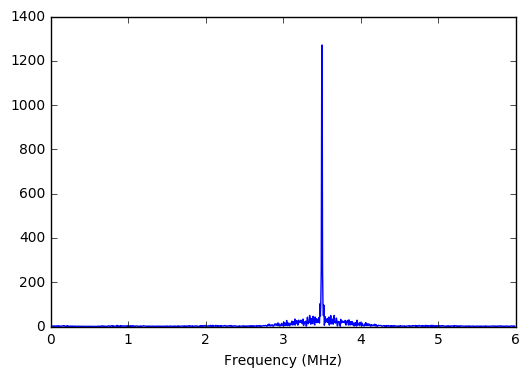

In [33]:
MaxFreq = 6.0E6
XLimit = int(L*MaxFreq/sps) # upper cap to 
print(XLimit)
LineFFT = np.abs(np.fft.fft(Line))
XScale = range(XLimit)
for i in range(XLimit):
    XScale[i] = (60.0E6)*float(XScale[i])/(L*(1.0E6))
plt.plot(XScale,LineFFT[0:XLimit]) # avec l'échelle
plt.xlabel('Frequency (MHz)')
plt.show()

Conclusion: our SinUs matches the raw signal for the fantom image !

# Let's find back our image from the signal table

We could at first get the absolute value of our signal, and decimate it to reconstruct our image

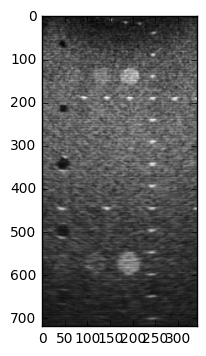

In [34]:
ReconstructedImage = np.zeros(shape=(Img.shape))
DecimationFactor = 1.0*SinUs.shape[0]/Img.shape[0]

for i in range(L):
       for j in range(Img.shape[1]): 
            ReconstructedImage[int(i/DecimationFactor)][j] += np.abs(SinUs[i][j])
            
ReconstructedImage = NormImag(np.abs(ReconstructedImage))

# Display it
ShowImage(ReconstructedImage)

We still get an error of 351 corresponding to:

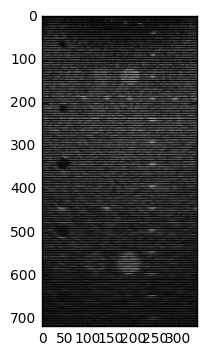

Error score of: 351.079080936
0.207490742924


In [37]:
ErrorMap = (Img - ReconstructedImage)
ShowImage(ErrorMap)
print("Error score of: "+str(ssd(ReconstructedImage,Img))) 
# Max deviation by pixel
print(ErrorMap.max())

## Challenge!

**Will you find a better way to get back to the original image, using the raw_signal.csv file, minimizing the error function?** Use the [original bitmap](fantom.bmp) as a reference to compare your results from the [raw signal dump](SinUs.csv.gz)!  

More to read for example on [this](http://sci-hub.cc/10.1117/1.3271168) -- or learn more about the filters with [this thesis: ARCHITECTURE D’UN PROCESSEUR DÉDIÉ AUX TRAITEMENTS DE SIGNAUX ULTRASONIQUES EN TEMPS RÉEL EN VUE D’UNE INTÉGRATION SUR PUCE](http://www.polystim.org/publications/publication_174.pdf).